# Introduction:

As technology becomes increasingly embedded in our daily lives, understanding human behaviour in digital environments has become essential—particularly for developers aiming to create more engaging and effective interactive experiences. Video games offer a unique opportunity for this kind of research because they capture detailed, real-time information about how players think, move, and make decisions within their online worlds.


A research group in UBC’s Department of Computer Science, led by Frank Wood, 
Is actively exploring this area by collecting data on how players interact with their custom Minecraft server and associated newsletter. Their project records their players’ total playtimes, ages, genders, etc., creating a rich dataset that reflects a wide range of observations unique to each player.


In this report, we use data-wrangling and analytical techniques to explore the ultimate question posed by Wood’s research team: “What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?” More specifically, we examine whether a player’s in-game server playtime and age can predict the likelihood of them subscribing to the newsletter.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

players_url <- "https://raw.githubusercontent.com/ellakiciman/dsci100-group-project-29/main/players%20(1).csv"
#read in data

players_data <- read_csv(players_url)
players_data

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


**Broad question:** What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

**Specific question:** Can we use time played on the server and age to predict the subscription status of users?

**Data:**  
***Players.csv:***
196 observations x 7 variables  
- experience (chr): pro, veteran, or amateur
- subscribe (lgl): are they subscribed?
- hashedEmail (chr): individual's encrypted email address
- played_hours (dbl): hours they played
- name (chr): name of individual
- gender (chr): Male, Female, non-binary, Agender, prefer not to say, or other
- age (dbl): age of individual

# Methods and Results:

**Summary of data set, loading and wrangling data:**

The first step in our analysis included creating a summary of the dataset we are using in order to gain an understanding of each of the variables. We also loaded the dataset and wrangled it in preparation for our analysis. This involved selecting only the relevant variables (subscribe, Age, and played_hours), as well as changing our class label variable to a factor data type.

In [2]:
# summary statistics of players data:
players_summary <- players_data |>
    summary(digits = 3)

players_summary

  experience        subscribe       hashedEmail         played_hours   
 Length:196         Mode :logical   Length:196         Min.   :  0.00  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.00  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.10  
                                                       Mean   :  5.85  
                                                       3rd Qu.:  0.60  
                                                       Max.   :223.10  
                                                                       
     name              gender               Age      
 Length:196         Length:196         Min.   : 9.0  
 Class :character   Class :character   1st Qu.:17.0  
 Mode  :character   Mode  :character   Median :19.0  
                                       Mean   :21.1  
                                       3rd Qu.:22.8  
                                       Max.   :58.0  
                                       NA's   

Data for 196 players. 
- Majority subscribed
- Age ranges from 9 to 58 y/o
  - Center falls around 19 (median)
- Most players spend little time online
  - at least 50% play <= 0.1 hr
  - high mean due to extreme outlier(s)

In [3]:
# wrangles and cleans the data to the format necessary for the planned analysis

players_clean <- players_data |>
  select(age = Age, played_hours, subscribe) |>
  mutate(
    age = as.numeric(age),
    played_hours = as.numeric(played_hours),
    subscribe = as_factor(subscribe)) |>
  drop_na()

players_clean

age,played_hours,subscribe
<dbl>,<dbl>,<fct>
9,30.3,TRUE
17,3.8,TRUE
17,0.0,FALSE
⋮,⋮,⋮
22,0.3,FALSE
57,0.0,FALSE
17,2.3,FALSE


**Exploratory data analysis:**

After loading and wrangling our dataset, we created an exploratory visualization of the variables relevant to our planned method of analysis. This involved creating a scatterplot of age and time played that was colored by whether someone was subscribed to the newsletter or not. This allowed us to get a sense of the potential relationship between these variables and whether or not age and time played would make good predictor variables for a classification model predicting subscription status.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


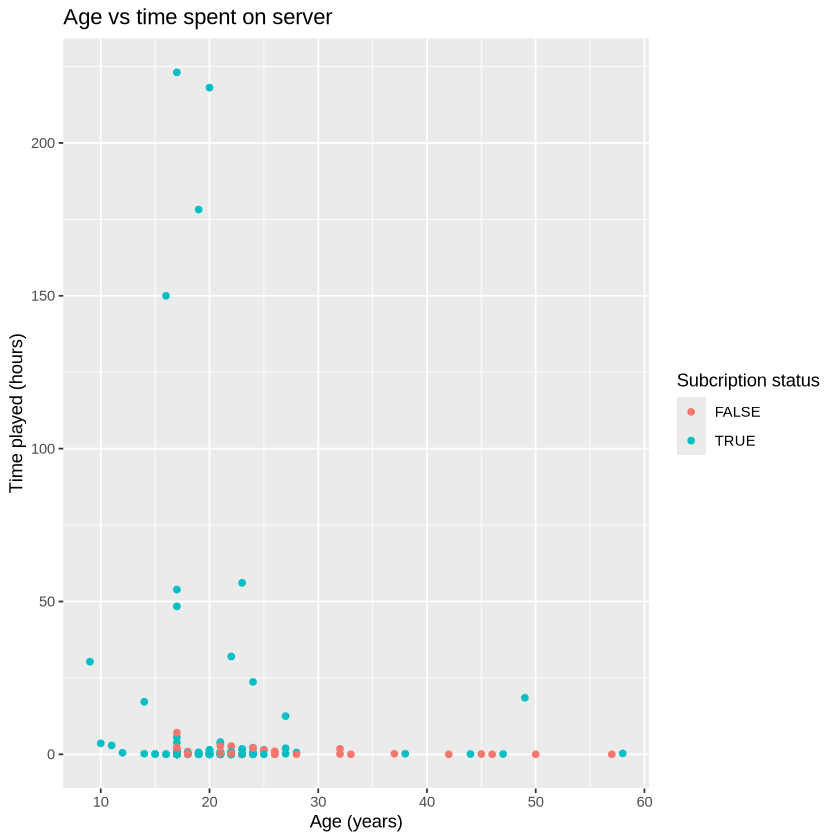

In [4]:
#exploratory data analysis
subscribe_plot <- players_data |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
        geom_point() +
        labs(x = "Age (years)", y = "Time played (hours)", 
             color = "Subcription status",
             title = "Age vs time spent on server")#exploratory data analysis
subscribe_plot

**Figure 1**: This visualization shows us how a k-nn classification model might function using these predictors. There is a lot of the data clustered near the bottom of the graph. Additionally, there is a large portion of the plot where there are no data points, so predicting a class label in this area might not lead to very accurate results.

**Data analysis (choosing k):**

Next, we went through all the steps of actually creating our k-nn classification model. We started by splitting the data into a training and testing set so that we would be able to fairly evaluate the accuracy of our model. We decided to put 75% of the data into the training set and 25% into the testing set. We then created our recipe for the model, and made sure to scale and center all of our predictors since the ranges of those variables were significantly different from one another. We also set up the knn model to be tuned to find the best value of k, which we did through a 5 fold cross validation that tested k values 2-25. We then collected the metrics from the tuning and created a visualization of the accuracy estimate for each k value.

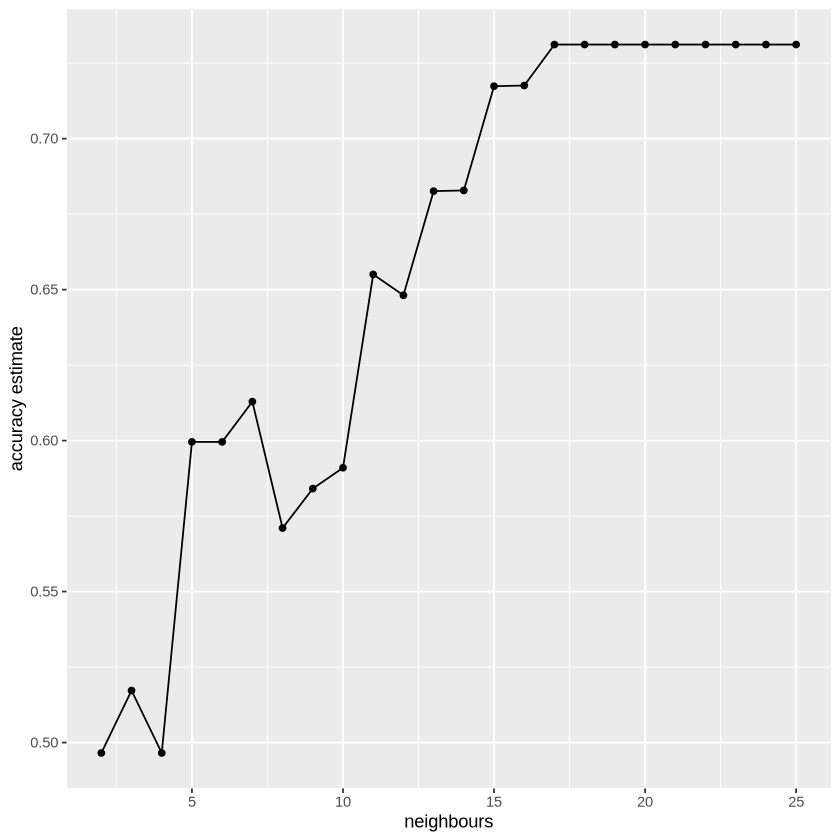

In [11]:
set.seed(2000)

players_split <- initial_split(players_clean, prop = 0.75, strata = subscribe)  
players_train <- training(players_split)
players_test <- testing(players_split)

players_recipe <- recipe(subscribe ~ ., data = players_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

data_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 2, to = 25, by = 1))

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

knn_results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = data_vfold, grid = k_vals) |>
      collect_metrics()

accuracy <- knn_results |>
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracy, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs( x = "neighbours", y = "accuracy estimate" )
cross_val_plot


**Figure 2**: This visualization shows which K is the most optimal for our analysis; the higher the accuracy estimate for the value of K, the better that K value will be for our model.

**Data analysis (using optimal k):**

After choosing the optimal k value, we created a new spec using that k and then fit the workflow to the training data to create our final model.

In [6]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
      set_engine("kknn") |>
      set_mode("classification")

knn_fit <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_spec) |>
      fit(data = players_train)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(17,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2689655
Best kernel: rectangular
Best k: 17

**Data analysis (testing the model):**

Finally, we tested the model using the testing dataset we had set aside at the beginning. We then collected the metrics in order to see the accuracy of the model on the testing data, and also created a confusion matrix in order to calculate the precision and recall of the k-nn classification model.

In [12]:
players_predictions <- predict(knn_fit, players_test) |>
    bind_cols(players_test)

players_metrics <- players_predictions |>
         metrics(truth = "subscribe", estimate = ".pred_class")

players_conf_mat <- players_predictions |>
    conf_mat(truth = "subscribe", estimate = ".pred_class")
players_conf_mat

          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     13   36